In [15]:
import glob
import pandas as pd
import numpy as np

### I. Forming the Dataframe

In [6]:
# getting all cases after 2015 and concatenating them into one dataframe

columns = ['ddl_case_id', 'year', 'state_code', 'dist_code', 'court_no', 'judge_position', 'female_defendant', 'female_petitioner', 'female_adv_def', 'female_adv_pet', 'type_name', 'purpose_name', 'disp_name']
cases = pd.concat([pd.read_csv(f, usecols = columns) for f in glob.glob('./csv/cases/*.csv') if int(f[18:22]) > 2015], ignore_index = True)

In [9]:
# read acts_sections.csv using chunking and merge with cases each chunk

columns = ['ddl_case_id', 'act', 'criminal']

# read acts_sections.csv for only the columns we need

acts_sections = pd.read_csv('./csv/acts_sections.csv', usecols = columns)

In [10]:
# merge cases with acts_sections based on ddl_case_id

cases = pd.merge(cases, acts_sections, on='ddl_case_id', how='left')

cases.head()

,ddl_case_id,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,act,criminal
0,01-01-01-201900000012016,2016,1,1,1,chief judicial magistrate,0 male,0 male,-9999,0,1940.0,767.0,26,14294.0,0.0
1,01-01-01-201900000022016,2016,1,1,1,chief judicial magistrate,0 male,0 male,-9999,0,1940.0,767.0,26,14294.0,0.0
2,01-01-01-201900000032016,2016,1,1,1,chief judicial magistrate,0 male,1 female,-9999,0,1940.0,4878.0,43,13707.0,0.0
3,01-01-01-201900000042016,2016,1,1,1,chief judicial magistrate,0 male,0 male,-9999,1,1940.0,7430.0,23,17353.0,1.0
4,01-01-01-201900000052016,2016,1,1,1,chief judicial magistrate,0 male,0 male,-9999,0,1940.0,5251.0,26,14294.0,0.0


### II. Data Cleaning & Preprocessing

In [16]:
cases_pre = cases.copy()

# removing columns that are not needed for the analysis
cases_pre = cases_pre.drop(['ddl_case_id'], axis=1)

# fill missing values with mode and drop all non-finite values
cases_pre = cases_pre.fillna(cases_pre.mode())

cases_pre = cases_pre.replace([np.inf, -np.inf], np.nan)
cases_pre = cases_pre.dropna()

cases_pre = cases_pre.drop_duplicates()

print(cases_pre.shape)

(8858713, 14)


In [17]:
# removing strings from the columns and making them integers

cases_pre['female_defendant'] = cases_pre['female_defendant'].str.replace('[a-zA-Z]', '', regex=True).astype('int')
cases_pre['female_petitioner'] = cases_pre['female_petitioner'].str.replace('[a-zA-Z]', '', regex=True).astype('int')

In [18]:
# remove cases where the genders are not mentioned or unclear 

cases_pre = cases_pre.loc[(cases_pre['female_adv_def'] != -9999) & (cases_pre['female_adv_def'] != -9998)]
cases_pre = cases_pre.loc[(cases_pre['female_adv_pet'] != -9999) & (cases_pre['female_adv_pet'] != -9998)]
cases_pre = cases_pre.loc[(cases_pre['female_defendant'] != -9999) & (cases_pre['female_defendant'] != -9998)]
cases_pre = cases_pre.loc[(cases_pre['female_petitioner'] != -9999) & (cases_pre['female_petitioner'] != -9998)]

In [19]:
cases_pre.head()

,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,act,criminal
5,2016,1,1,1,chief judicial magistrate,0,1,1,0,1940.0,2813.0,16,4759.0,1.0
11,2016,1,1,1,chief judicial magistrate,0,1,0,0,1940.0,5426.0,23,13707.0,0.0
12,2016,1,1,1,chief judicial magistrate,0,1,0,1,1940.0,2813.0,27,13707.0,0.0
18,2016,1,1,1,chief judicial magistrate,0,1,0,0,1940.0,767.0,33,13707.0,0.0
37,2016,1,1,1,chief judicial magistrate,0,0,0,0,1940.0,2813.0,46,13707.0,0.0


#### Saving up on memory by downcasting the data types of the columns

In [20]:
cases_pre.dtypes

year                   int64
state_code             int64
dist_code              int64
court_no               int64
judge_position        object
female_defendant       int64
female_petitioner      int64
female_adv_def         int64
female_adv_pet         int64
type_name            float64
purpose_name         float64
disp_name              int64
act                  float64
criminal             float64
dtype: object

In [21]:
cases_pre.memory_usage(deep=True)

Index                 2897816
year                  2897816
state_code            2897816
dist_code             2897816
court_no              2897816
judge_position       28803516
female_defendant      2897816
female_petitioner     2897816
female_adv_def        2897816
female_adv_pet        2897816
type_name             2897816
purpose_name          2897816
disp_name             2897816
act                   2897816
criminal              2897816
dtype: int64

In [23]:
# downcasting the data types

cases_pre['judge_position'] = cases_pre['judge_position'].astype('category')
cases_pre[['type_name', 'purpose_name', 'act', 'criminal']] = cases_pre[['type_name', 'purpose_name', 'act', 'criminal']].astype('uint8')
cases_pre[['year', 'state_code', 'dist_code', 'court_no', 'disp_name', 'female_defendant', 'female_petitioner', 'female_adv_def', 'female_adv_pet', 'type_name', 'purpose_name', 'act', 'criminal']] = cases_pre[['year', 'state_code', 'dist_code', 'court_no', 'disp_name', 'female_defendant', 'female_petitioner', 'female_adv_def', 'female_adv_pet', 'type_name', 'purpose_name', 'act', 'criminal']].apply(pd.to_numeric, downcast='unsigned')

In [24]:
cases_pre.dtypes

year                   uint16
state_code              uint8
dist_code               uint8
court_no                uint8
judge_position       category
female_defendant        uint8
female_petitioner       uint8
female_adv_def          uint8
female_adv_pet          uint8
type_name               uint8
purpose_name            uint8
disp_name               uint8
act                     uint8
criminal                uint8
dtype: object

In [55]:
# ordinal encoding of judge_position

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
cases_pre['judge_position'] = encoder.fit_transform(cases_pre[['judge_position']])
cases_pre['judge_position'] = cases_pre['judge_position'].astype('uint8')

In [26]:
cases_pre.head()

,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,act,criminal
5,2016,1,1,1,101,0,1,1,0,148,253,16,151,1
11,2016,1,1,1,101,0,1,0,0,148,50,23,139,0
12,2016,1,1,1,101,0,1,0,1,148,253,27,139,0
18,2016,1,1,1,101,0,1,0,0,148,255,33,139,0
37,2016,1,1,1,101,0,0,0,0,148,253,46,139,0


#### Compare the correlation of attributes to select the best ones for the model

<AxesSubplot: >

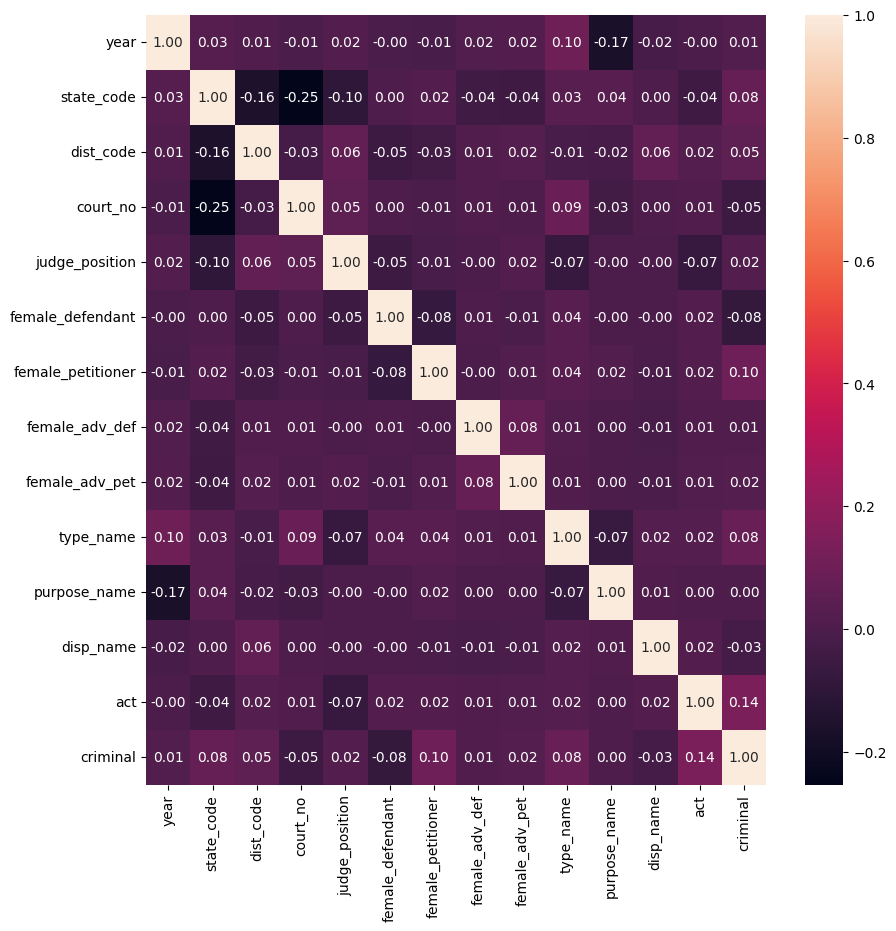

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
 
# correlation matrix
corr = cases_pre.corr(numeric_only=True)
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.2f')

#### Check which attributes are relevant

In [59]:
# chi square test to get 10 best predictors for criminal

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = cases_pre.drop(['criminal'], axis=1)
y = cases_pre['criminal']

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  

featureScores.nlargest(10,'Score')


,Specs,Score
12,act,199395.589327
9,type_name,90565.867381
1,state_code,14901.204693
2,dist_code,8301.907492
3,court_no,7914.707381
4,judge_position,2721.157338
6,female_petitioner,2366.982147
5,female_defendant,1821.546644
11,disp_name,1087.816554
10,purpose_name,243.576615


In [40]:
cases_pre.head()

,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,act,criminal
5,2016,1,1,1,101,0,1,1,0,148,253,16,151,1
11,2016,1,1,1,101,0,1,0,0,148,50,23,139,0
12,2016,1,1,1,101,0,1,0,1,148,253,27,139,0
18,2016,1,1,1,101,0,1,0,0,148,255,33,139,0
37,2016,1,1,1,101,0,0,0,0,148,253,46,139,0


In [104]:
# drop the columns that are not needed for the classification

relevant_data = cases_pre.drop(['female_adv_def', 'female_adv_pet', 'year'], axis=1)
relevant_data = relevant_data.drop_duplicates()
relevant_data.head()

,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,type_name,purpose_name,disp_name,act,criminal
5,1,1,1,101,0,1,148,253,16,151,1
11,1,1,1,101,0,1,148,50,23,139,0
12,1,1,1,101,0,1,148,253,27,139,0
18,1,1,1,101,0,1,148,255,33,139,0
37,1,1,1,101,0,0,148,253,46,139,0


### III. Classification

#### Train Test Split

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

X = relevant_data.drop(['criminal'], axis=1)
y = relevant_data['criminal']

X_train, X_test, y_train, y_test = train_test_split(X, y)


#### Various Classification Models

SVMs are not suitable for large datasets.
The original SVM implementation is known to have a concrete theoretical foundation, but it is not suitable for classifying in large datasets for one straightforward reason — the complexity of the algorithm's training is highly dependent on the size of the dataset.

In [103]:
# logistic regression

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

# confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# classification report
print(classification_report(y_test, y_pred))

# get roc auc score
logreg_fp, logreg_tp, _ = roc_curve(y_test, y_pred)

Accuracy of logistic regression classifier on test set: 0.83
[[68606    81]
 [14412    33]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.90     68687
           1       0.29      0.00      0.00     14445

    accuracy                           0.83     83132
   macro avg       0.56      0.50      0.45     83132
weighted avg       0.73      0.83      0.75     83132



In [117]:
# naive bayes

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print('Accuracy of naive bayes classifier on test set: {:.2f}'.format(gnb.score(X_test, y_test)))

# confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# classification report
print(classification_report(y_test, y_pred))

# get roc auc score
gnb_fp, gnb_tp, _ = roc_curve(y_test, y_pred)

Accuracy of naive bayes classifier on test set: 0.85
[[67097  1594]
 [11091  3350]]
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     68691
           1       0.68      0.23      0.35     14441

    accuracy                           0.85     83132
   macro avg       0.77      0.60      0.63     83132
weighted avg       0.83      0.85      0.81     83132



In [106]:
# knn

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Accuracy of KNN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

# confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# classification report
print(classification_report(y_test, y_pred))

# get roc auc score
knn_fp, knn_tp, _ = roc_curve(y_test, y_pred)

Accuracy of KNN classifier on test set: 0.97
[[67343  1359]
 [  962 13468]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     68702
           1       0.91      0.93      0.92     14430

    accuracy                           0.97     83132
   macro avg       0.95      0.96      0.95     83132
weighted avg       0.97      0.97      0.97     83132



In [112]:
# decision tree

from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

print('Accuracy of decision tree classifier on test set: {:.2f}'.format(dtree.score(X_test, y_test)))

# confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# classification report
print(classification_report(y_test, y_pred))

# get roc auc score
dt_fp, dt_tp, _ = roc_curve(y_test, y_pred)

Accuracy of decision tree classifier on test set: 1.00
[[68792    10]
 [   15 14315]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68802
           1       1.00      1.00      1.00     14330

    accuracy                           1.00     83132
   macro avg       1.00      1.00      1.00     83132
weighted avg       1.00      1.00      1.00     83132



In [114]:
# random forest 

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print('Accuracy of random forest classifier on test set: {:.2f}'.format(rfc.score(X_test, y_test)))

# confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix) 

# classification report
print(classification_report(y_test, y_pred))

# get roc auc score
rf_fp, rf_tp, _ = roc_curve(y_test, y_pred)

Accuracy of random forest classifier on test set: 1.00
[[68679    17]
 [    0 14436]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68696
           1       1.00      1.00      1.00     14436

    accuracy                           1.00     83132
   macro avg       1.00      1.00      1.00     83132
weighted avg       1.00      1.00      1.00     83132



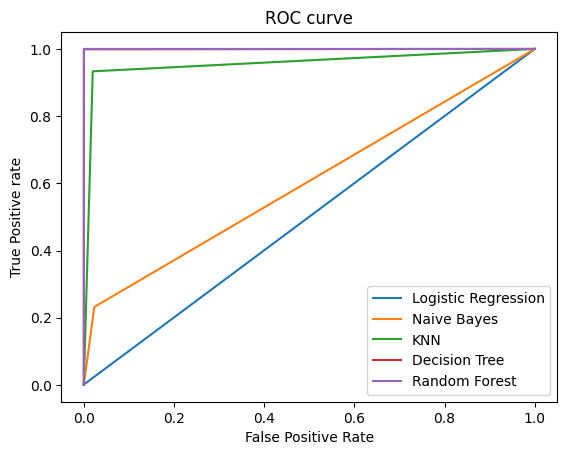

In [119]:
# roc curve for all models

plt.plot(logreg_fp, logreg_tp, label='Logistic Regression')
plt.plot(gnb_fp, gnb_tp, label='Naive Bayes')
plt.plot(knn_fp, knn_tp, label='KNN')
plt.plot(dt_fp, dt_tp, label='Decision Tree')
plt.plot(rf_fp, rf_tp, label='Random Forest')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')